<a href="https://colab.research.google.com/github/ARJUN108-verma/LLMs-Large-Language-Models-/blob/main/Text_Classification_with_XLNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text Classification with XLNET:-

In [10]:
!pip install cleantext

In [11]:
!pip install clean

In [12]:
import pandas as pd
import numpy as np
import cleantext as clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, pipeline, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [14]:
!pip install datasets

In [15]:
!pip install evaluate

In [16]:
import datasets
import evaluate
import random

Preprocess the data:-

In [17]:
data_val = pd.read_csv("/content/emotion-labels-val.csv")
data_train = pd.read_csv("/content/emotion-labels-train.csv")
data_test = pd.read_csv("/content/emotion-labels-test.csv")

In [18]:
data_val.head()

,text,label
0,"@theclobra lol I thought maybe, couldn't decid...",joy
1,Nawaz Sharif is getting more funnier than @kap...,joy
2,Nawaz Sharif is getting more funnier than @kap...,joy
3,@tomderivan73 😁...I'll just people watch and e...,joy
4,I love my family so much #lucky #grateful #sma...,joy


In [19]:
data_train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [20]:
data_test.head()

,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy


In [21]:
data = pd.concat([data_train, data_val, data_test], ignore_index=True)

In [22]:
import cleantext as clean

In [23]:

data['text_clean'] = data['text'].apply(lambda x: clean.clean(x, clean_all= True, extra_spaces=True))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:

data['text_clean'] = data['text_clean'].apply(lambda x: re.sub(r'http\S+', '', x))

In [25]:
data.head(27)

,text,label,text_clean
0,Just got back from seeing @GaryDelaney in Burs...,joy,Just got back from seeing @GaryDelaney in Burs...
1,Oh dear an evening of absolute hilarity I don'...,joy,Oh dear an evening of absolute hilarity I don'...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,Been waiting all week for this game ❤️❤️❤️ #ch...
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,"@gardiner_love : Thank you so much, Gloria! Yo..."
4,I feel so blessed to work with the family that...,joy,I feel so blessed to work with the family that...
5,"Today I reached 1000 subscribers on YT!! , #go...",joy,"Today I reached 1000 subscribers on YT!! , #go..."
6,"@Singaholic121 Good morning, love! Happy first...",joy,"@Singaholic121 Good morning, love! Happy first..."
7,#BridgetJonesBaby is the best thing I've seen ...,joy,#BridgetJonesBaby is the best thing I've seen ...
8,Just got back from seeing @GaryDelaney in Burs...,joy,Just got back from seeing @GaryDelaney in Burs...
9,@IndyMN I thought the holidays could not get a...,joy,@IndyMN I thought the holidays could not get a...


<Axes: xlabel='label'>

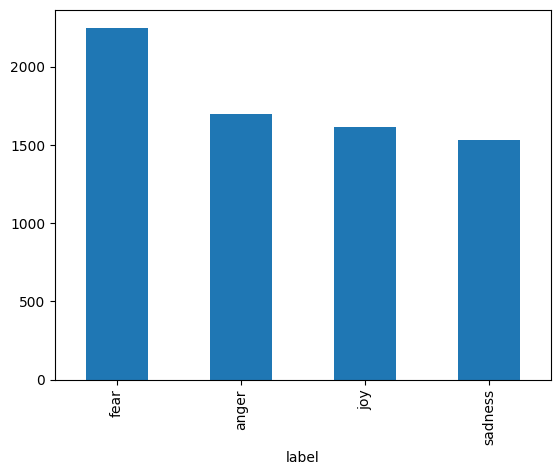

In [26]:
data['label'].value_counts().plot(kind='bar')

In [27]:
g = data.groupby('label')

In [28]:
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

/tmp/ipython-input-2703046170.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))


<Axes: xlabel='label'>

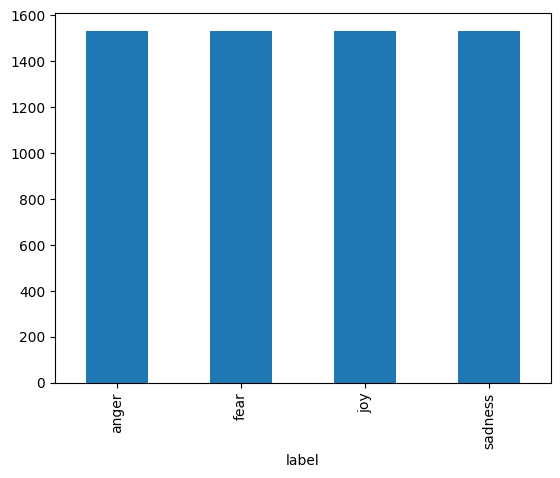

In [29]:
data['label'].value_counts().plot(kind='bar')

In [30]:

data['label'] = LabelEncoder().fit_transform(data['label'])

In [31]:
NUM_LABELS = 4

Split:-

In [32]:
train_split, test_split = train_test_split(data, test_size=0.2, random_state=42)

In [33]:

train_slit, val_split = train_test_split(train_split, train_size = 0.9)

In [34]:
print(len(train_slit))
print(len(val_split))
print(len(test_split))

4414
491
1227


In [35]:
print(train_split.columns)

Index(['text', 'label', 'text_clean'], dtype='object')


In [36]:
train_df = pd.DataFrame({
    "label": train_split["label"].values,
    "text": train_split["text_clean"].values
})

In [37]:
train_split["label_int"] = train_split["label"].astype('category').cat.codes

In [38]:
test_df = pd.DataFrame({
    "label": train_split["label_int"].values,
    "text": train_split["text_clean"].values
})


In [39]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_df.to_dict("list"))
test_dataset = Dataset.from_dict(test_df.to_dict("list"))

In [40]:
dataset_dict = datasets.DatasetDict({"train":train_df, "test":test_df})

In [41]:
dataset_dict


DatasetDict({
    train:       label                                               text
    0         2  So much news about Pakistan, Afghanistan, etc....
    1         0  Sorry guys I have absolutely no idea what time...
    2         1    quentin i sait aps dire eastpak i dit aspak msk
    3         1  3years today marks the anniversary of that hor...
    4         0                @Idubbbz @LeafyIsHere I am offended
    ...     ...                                                ...
    4900      2  Asked one thing from our guys tonight and got ...
    4901      3  I mourn. ha..r / ambe was ruined. what was onc...
    4902      3  @JlKelly1 @FJ_Berry I've got #teampaella prese...
    4903      3                                          depress 😭
    4904      0  @ReadingFC @EFLCup - remind them 'Twenty's Ple...
    
    [4905 rows x 2 columns]
    test:       label                                               text
    0         2  So much news about Pakistan, Afghanistan, etc....
  

Create embeddings:-

In [42]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [43]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)

In [44]:
from datasets import Dataset, DatasetDict

In [45]:
dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})

In [46]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/4905 [00:00<?, ? examples/s]

Map:   0%|          | 0/4905 [00:00<?, ? examples/s]

In [47]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4905
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4905
    })
})

In [48]:
print(tokenized_datasets['train']['text'][0])

So much news about Pakistan, Afghanistan, etc. We need more cheery news about Frybread Stands!!! Everyone in media just so grim.


In [49]:
print(tokenized_datasets['train']['input_ids'][0])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 346, 178, 546, 75, 1462, 19, 1805, 19, 1813, 9, 169, 214, 70, 10259, 117, 546, 75, 20224, 24575, 15884, 23, 12791, 7809, 25, 789, 125, 102, 9182, 9, 4, 3]


In [50]:
tokenizer.decode(5)

'<pad>'

In [51]:
print(tokenized_datasets['train']['token_type_ids'][0])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


In [52]:
print(tokenized_datasets['train']['attention_mask'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [53]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

Fine tune our model:-

In [54]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',
                                                       num_labels=NUM_LABELS,
                                                       id2label={0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'})

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Add `%load_ext cudf.pandas` before importing pandas to speed up operations using GPU

In [55]:
metric = evaluate.load("accuracy")

In [56]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [57]:
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch", num_train_epochs=3)

In [58]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics)

In [59]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 27012000arjunmaurya (27012000arjunmaurya-babu-banarsi-das-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.339944,0.330000
2,No log,1.338707,0.530000
3,No log,1.291401,0.490000


TrainOutput(global_step=39, training_loss=1.4103150979066505, metrics={'train_runtime': 742.1279, 'train_samples_per_second': 0.404, 'train_steps_per_second': 0.053, 'total_flos': 21366375321600.0, 'train_loss': 1.4103150979066505, 'epoch': 3.0})

Evaluate model:-



In [60]:
trainer.evaluate()


{'eval_loss': 1.2914009094238281,
 'eval_accuracy': 0.49,
 'eval_runtime': 48.7605,
 'eval_samples_per_second': 2.051,
 'eval_steps_per_second': 0.267,
 'epoch': 3.0}

In [61]:
model.save_pretrained("fine_tuned_model")

In [62]:

fine_tuned_model = XLNetForSequenceClassification.from_pretrained("fine_tuned_model")

In [63]:


clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)


Device set to use cpu


In [64]:
rand_int = random.randint(0, len(val_split))
print(val_split['text_clean'][rand_int])
answer = clf(val_split['text_clean'][rand_int], top_k=None)
print(answer)

/tmp/ipython-input-3116462782.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(val_split['text_clean'][rand_int])
/tmp/ipython-input-3116462782.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  answer = clf(val_split['text_clean'][rand_int], top_k=None)


@TheDappaMc also £2.50 for a chocolate Feast ice lolly.. proper shocking 😩
[{'label': 'sadness', 'score': 0.28312087059020996}, {'label': 'fear', 'score': 0.28197163343429565}, {'label': 'joy', 'score': 0.2270493358373642}, {'label': 'anger', 'score': 0.20785817503929138}]


In [65]:
!pip install --upgrade ipywidgets jupyter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Atte

In [66]:
!jupyter nbconvert --clear-output --inplace your_notebook.ipynb


[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 